In [186]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [187]:
# Loading telecom dataset
telecom_data = pd.read_csv('cellular_dataframe.csv')

# remove nan values in latitudes and longitudes in telecom_data
telecom_data = telecom_data[~np.isnan(telecom_data['Latitude'])]
telecom_data = telecom_data[~np.isnan(telecom_data['Longitude'])]
#remove nan values in PCell_Downlink_Num_RBs, PCell_Downlink_TB_Size, SCell_Downlink_TB_Size and datarate
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_28'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_31'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['datarate'])]

# # selecting a random 10000 rows from the dataset
# telecom_data = telecom_data.sample(n=20000, random_state=42)
#normalizing the datarate using min-max normalization
telecom_data['datarate'] = ((np.max(telecom_data['datarate'])-telecom_data['datarate'])*100)/(np.max(telecom_data['datarate'])-np.min(telecom_data['datarate']))

#splitting the dataset into train and test sets
train_data, test_data = train_test_split(telecom_data, test_size=0.2, random_state=42)

telecom_data = train_data

print(telecom_data.shape)
print(test_data.shape)

# Extract relevant features and labels
features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
# # normalizing the labels using min-max normalization
# labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))

 
# Extract latitudes and longitudes
latitudes = telecom_data['Latitude'].values
longitudes = telecom_data['Longitude'].values

(3319, 159)
(664, 159)


In [188]:
# finding min and max values of labels
print(np.min(labels), np.max(labels))

0.0 100.0


In [189]:
# Calculate pairwise distances using Haversine formula
coordinates = np.column_stack((latitudes, longitudes))
dist_matrix = haversine_distances(np.radians(coordinates))

# Define distance threshold for edges
distance_threshold = 1 # For example, consider nodes within 1 km as neighbors

In [190]:

# Create adjacency matrix based on distance threshold
adj_matrix = (dist_matrix <= distance_threshold).astype(int)

# Convert adjacency matrix to edge indices
edge_indices = np.transpose(np.nonzero(adj_matrix))
edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [191]:
adj_matrix.shape

(3319, 3319)

In [192]:
# count the number of edges
np.count_nonzero(adj_matrix)

11015761

In [193]:
# Split data into train and test sets
X_train, y_train = features,labels
y_train= y_train.reshape(-1,1)

In [194]:
X_train.shape

(3319, 8)

In [195]:
# Convert data to tensors
x = torch.FloatTensor(X_train)
y = torch.FloatTensor(y_train)

In [196]:
# Create a graph data object using torch_geometric
data = Data(x=x, edge_index=edge_indices, y=y)

In [197]:
from torch_geometric.nn import SAGEConv
import pytorch_spiking

class ComplexGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexGNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.conv5 = SAGEConv(hidden_dim, hidden_dim)
        self.conv6 = SAGEConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization

        # Defining the spiking activation
        self.spiking_activation = pytorch_spiking.SpikingActivation(torch.nn.ReLU(),dt=0.1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension

        x = self.conv4(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv5(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension

        x = self.conv6(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        
        x = self.linear1(x)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        
        x = self.linear2(x)

        return x

In [198]:
# Define your loss function and optimizer
gnn_model = ComplexGNN(input_dim=features.shape[1], hidden_dim=16, output_dim=1)
# # loading a pytorch model from a saved state dict
# gnn_model.load_state_dict(torch.load('lat_long_node_GNN_rsrp_spiking.pth'))
loss_function = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)

# Create a DataLoader for batching your data
dataloader = DataLoader([data], batch_size=200)

In [199]:
# # loading training and validation loss from a pickle file
# import pickle
# with open('lat_long_node_GNN_rsrp_spiking.pkl', 'rb') as f:
#     training_acc, validation_acc = pickle.load(f)

In [200]:
training_acc = []
validation_acc = []

In [293]:
def get_validation(test_data):
    telecom_data = test_data
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    # # normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
     
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # For example, consider nodes within 10 km as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=664)
    # Evaluation on test set
    gnn_model.eval()
    with torch.no_grad():
        for batch_data in dataloader:
            #print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
            output = gnn_model(batch_data.x, batch_data.edge_index)
            loss = loss_function(output, batch_data.y)
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
            #print mape using sklearn
            return loss.item()

In [ ]:
# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    #setting best validation loss to infinity
    best_val_loss = np.inf
    for batch_data in dataloader:
        optimizer.zero_grad()
        # print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
        output = gnn_model(batch_data.x, batch_data.edge_index)
        loss = loss_function(output, batch_data.y)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
        val_loss = get_validation(test_data)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {(val_loss):.4f}")
        print("--------------------------------------------------")
        training_acc.append(loss.item())
        validation_acc.append(val_loss)
        # saving the model with best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_rsrp_spiking_best.pth')

Epoch [1/1000], Batch Loss: 99.5800
Epoch [1/1000], Validation Loss: 110.8355
--------------------------------------------------
Epoch [2/1000], Batch Loss: 99.2428
Epoch [2/1000], Validation Loss: 108.6410
--------------------------------------------------
Epoch [3/1000], Batch Loss: 100.7994
Epoch [3/1000], Validation Loss: 107.5257
--------------------------------------------------
Epoch [4/1000], Batch Loss: 100.5765
Epoch [4/1000], Validation Loss: 107.2432
--------------------------------------------------
Epoch [5/1000], Batch Loss: 99.9075
Epoch [5/1000], Validation Loss: 108.0723
--------------------------------------------------
Epoch [6/1000], Batch Loss: 99.1928
Epoch [6/1000], Validation Loss: 109.6905
--------------------------------------------------
Epoch [7/1000], Batch Loss: 98.0601
Epoch [7/1000], Validation Loss: 108.8204
--------------------------------------------------
Epoch [8/1000], Batch Loss: 99.0181
Epoch [8/1000], Validation Loss: 106.9845
-----------------

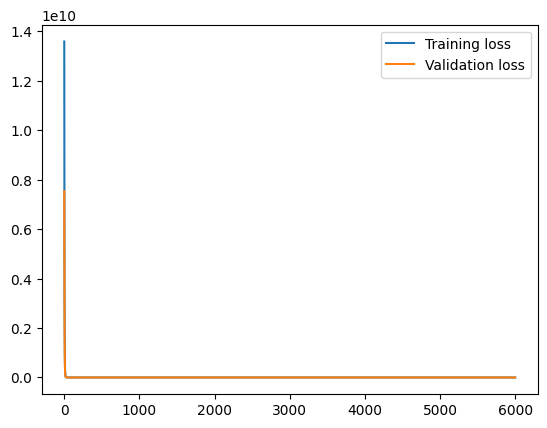

In [224]:
# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_acc, label='Training loss')
plt.plot(validation_acc, label='Validation loss')
plt.legend()
plt.show()

In [299]:
print(min(validation_acc))
# 89.89

82.332275390625


In [300]:
len(validation_acc)

8000

In [319]:
# print last 10 validation losses
print(validation_acc[-100:])

[90.25334930419922, 88.5505142211914, 87.63139343261719, 87.3066635131836, 88.60247802734375, 86.16129302978516, 88.67098999023438, 86.09484100341797, 88.38377380371094, 87.3938217163086, 86.51296997070312, 85.82942199707031, 85.8031005859375, 86.54318237304688, 87.84183502197266, 90.85400390625, 87.3396224975586, 87.38410949707031, 85.98375701904297, 84.3191146850586, 88.575439453125, 86.84466552734375, 89.15631103515625, 85.95929718017578, 84.1384506225586, 84.51542663574219, 86.81652069091797, 89.70099639892578, 86.13388061523438, 87.99203491210938, 86.08554077148438, 85.39020538330078, 87.07389068603516, 87.90162658691406, 84.36145782470703, 88.82559967041016, 86.01966857910156, 87.24775695800781, 85.3617172241211, 87.48590850830078, 88.25421905517578, 86.74718475341797, 85.99500274658203, 86.35236358642578, 85.8949966430664, 87.22938537597656, 86.4119873046875, 82.332275390625, 85.58155059814453, 86.68164825439453, 87.26866149902344, 86.78034973144531, 88.36884307861328, 85.410469

In [316]:
# saving the model
torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_rsrp_spiking.pth')

In [317]:
# saving the validation loss and training loss as a pickle file
import pickle
with open('lat_long_node_GNN_rsrp_spiking.pkl', 'wb') as f:
    pickle.dump([training_acc, validation_acc], f)

In [304]:
def evaluate_model(telecom_data):
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    
    # # Normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # Consider nodes within specified distance as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=664)
    
    # Evaluation on test set
    gnn_model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_data in dataloader:
            output = gnn_model(batch_data.x, batch_data.edge_index)
            
            true_labels.extend(batch_data.y.numpy())
            predicted_labels.extend(output.numpy())

    return true_labels, predicted_labels

In [305]:
a,b = evaluate_model(telecom_data=test_data)

In [306]:
print(a)

[array([68.69766], dtype=float32), array([64.0784], dtype=float32), array([48.409866], dtype=float32), array([68.25421], dtype=float32), array([85.84436], dtype=float32), array([52.105274], dtype=float32), array([52.844357], dtype=float32), array([49.14895], dtype=float32), array([73.464745], dtype=float32), array([48.409866], dtype=float32), array([66.7391], dtype=float32), array([81.705505], dtype=float32), array([35.10639], dtype=float32), array([41.75813], dtype=float32), array([49.888027], dtype=float32), array([73.68647], dtype=float32), array([30.302359], dtype=float32), array([65.076164], dtype=float32), array([61.3438], dtype=float32), array([92.0157], dtype=float32), array([28.824194], dtype=float32), array([30.6719], dtype=float32), array([60.604717], dtype=float32), array([57.278847], dtype=float32), array([77.75142], dtype=float32), array([42.866753], dtype=float32), array([74.092964], dtype=float32), array([90.35276], dtype=float32), array([60.235176], dtype=float32), arr

In [307]:
print(b)

[array([62.36409], dtype=float32), array([62.911453], dtype=float32), array([43.472], dtype=float32), array([64.541824], dtype=float32), array([83.34456], dtype=float32), array([55.88069], dtype=float32), array([59.930984], dtype=float32), array([44.124344], dtype=float32), array([83.62581], dtype=float32), array([59.223953], dtype=float32), array([70.39485], dtype=float32), array([82.63704], dtype=float32), array([32.17122], dtype=float32), array([34.63655], dtype=float32), array([59.85286], dtype=float32), array([67.109695], dtype=float32), array([38.20784], dtype=float32), array([60.535965], dtype=float32), array([59.94026], dtype=float32), array([74.371414], dtype=float32), array([45.148758], dtype=float32), array([25.86653], dtype=float32), array([61.96028], dtype=float32), array([45.86116], dtype=float32), array([62.309402], dtype=float32), array([51.745438], dtype=float32), array([86.379715], dtype=float32), array([93.02669], dtype=float32), array([39.302567], dtype=float32), ar

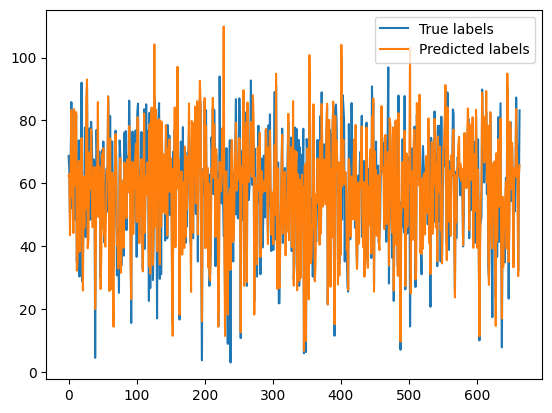

In [308]:
# plotting the graph for a and b
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()

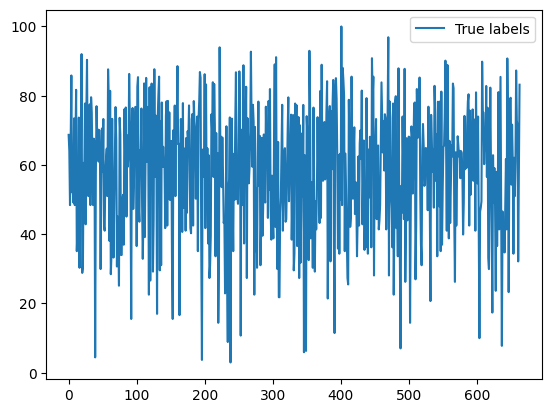

In [309]:
# displaying the true and predicted labels in different graphs
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.legend()
plt.show()

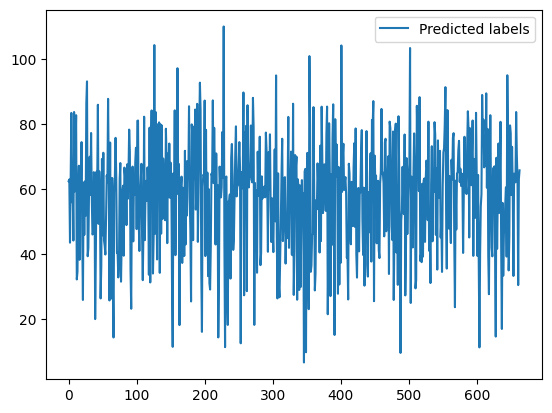

In [310]:
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()


In [311]:
# calculating the mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(a,b)

6.623847

In [312]:
# calculating the mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b)

87.57329

In [313]:
# calculating the root mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b, squared=False)

9.35806

In [314]:
# calculating the r2 score
from sklearn.metrics import r2_score
r2_score(a,b)

0.7488279062175216

In [315]:
# printing the mean absolute percentage error using sklearn
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(a,b)

0.1611617